In [118]:
import numpy as np
import pylab as plt
import math as m
import tifffile

Goals for accuracy

-Greater than 80% positive

-Manual verification

-IMARIS is SOTA

-106.7/5 = 21.34 is nm/pixel

Number of frames: 4
Shape of each frame: (2560, 2560)
Data type of each pixel: float32


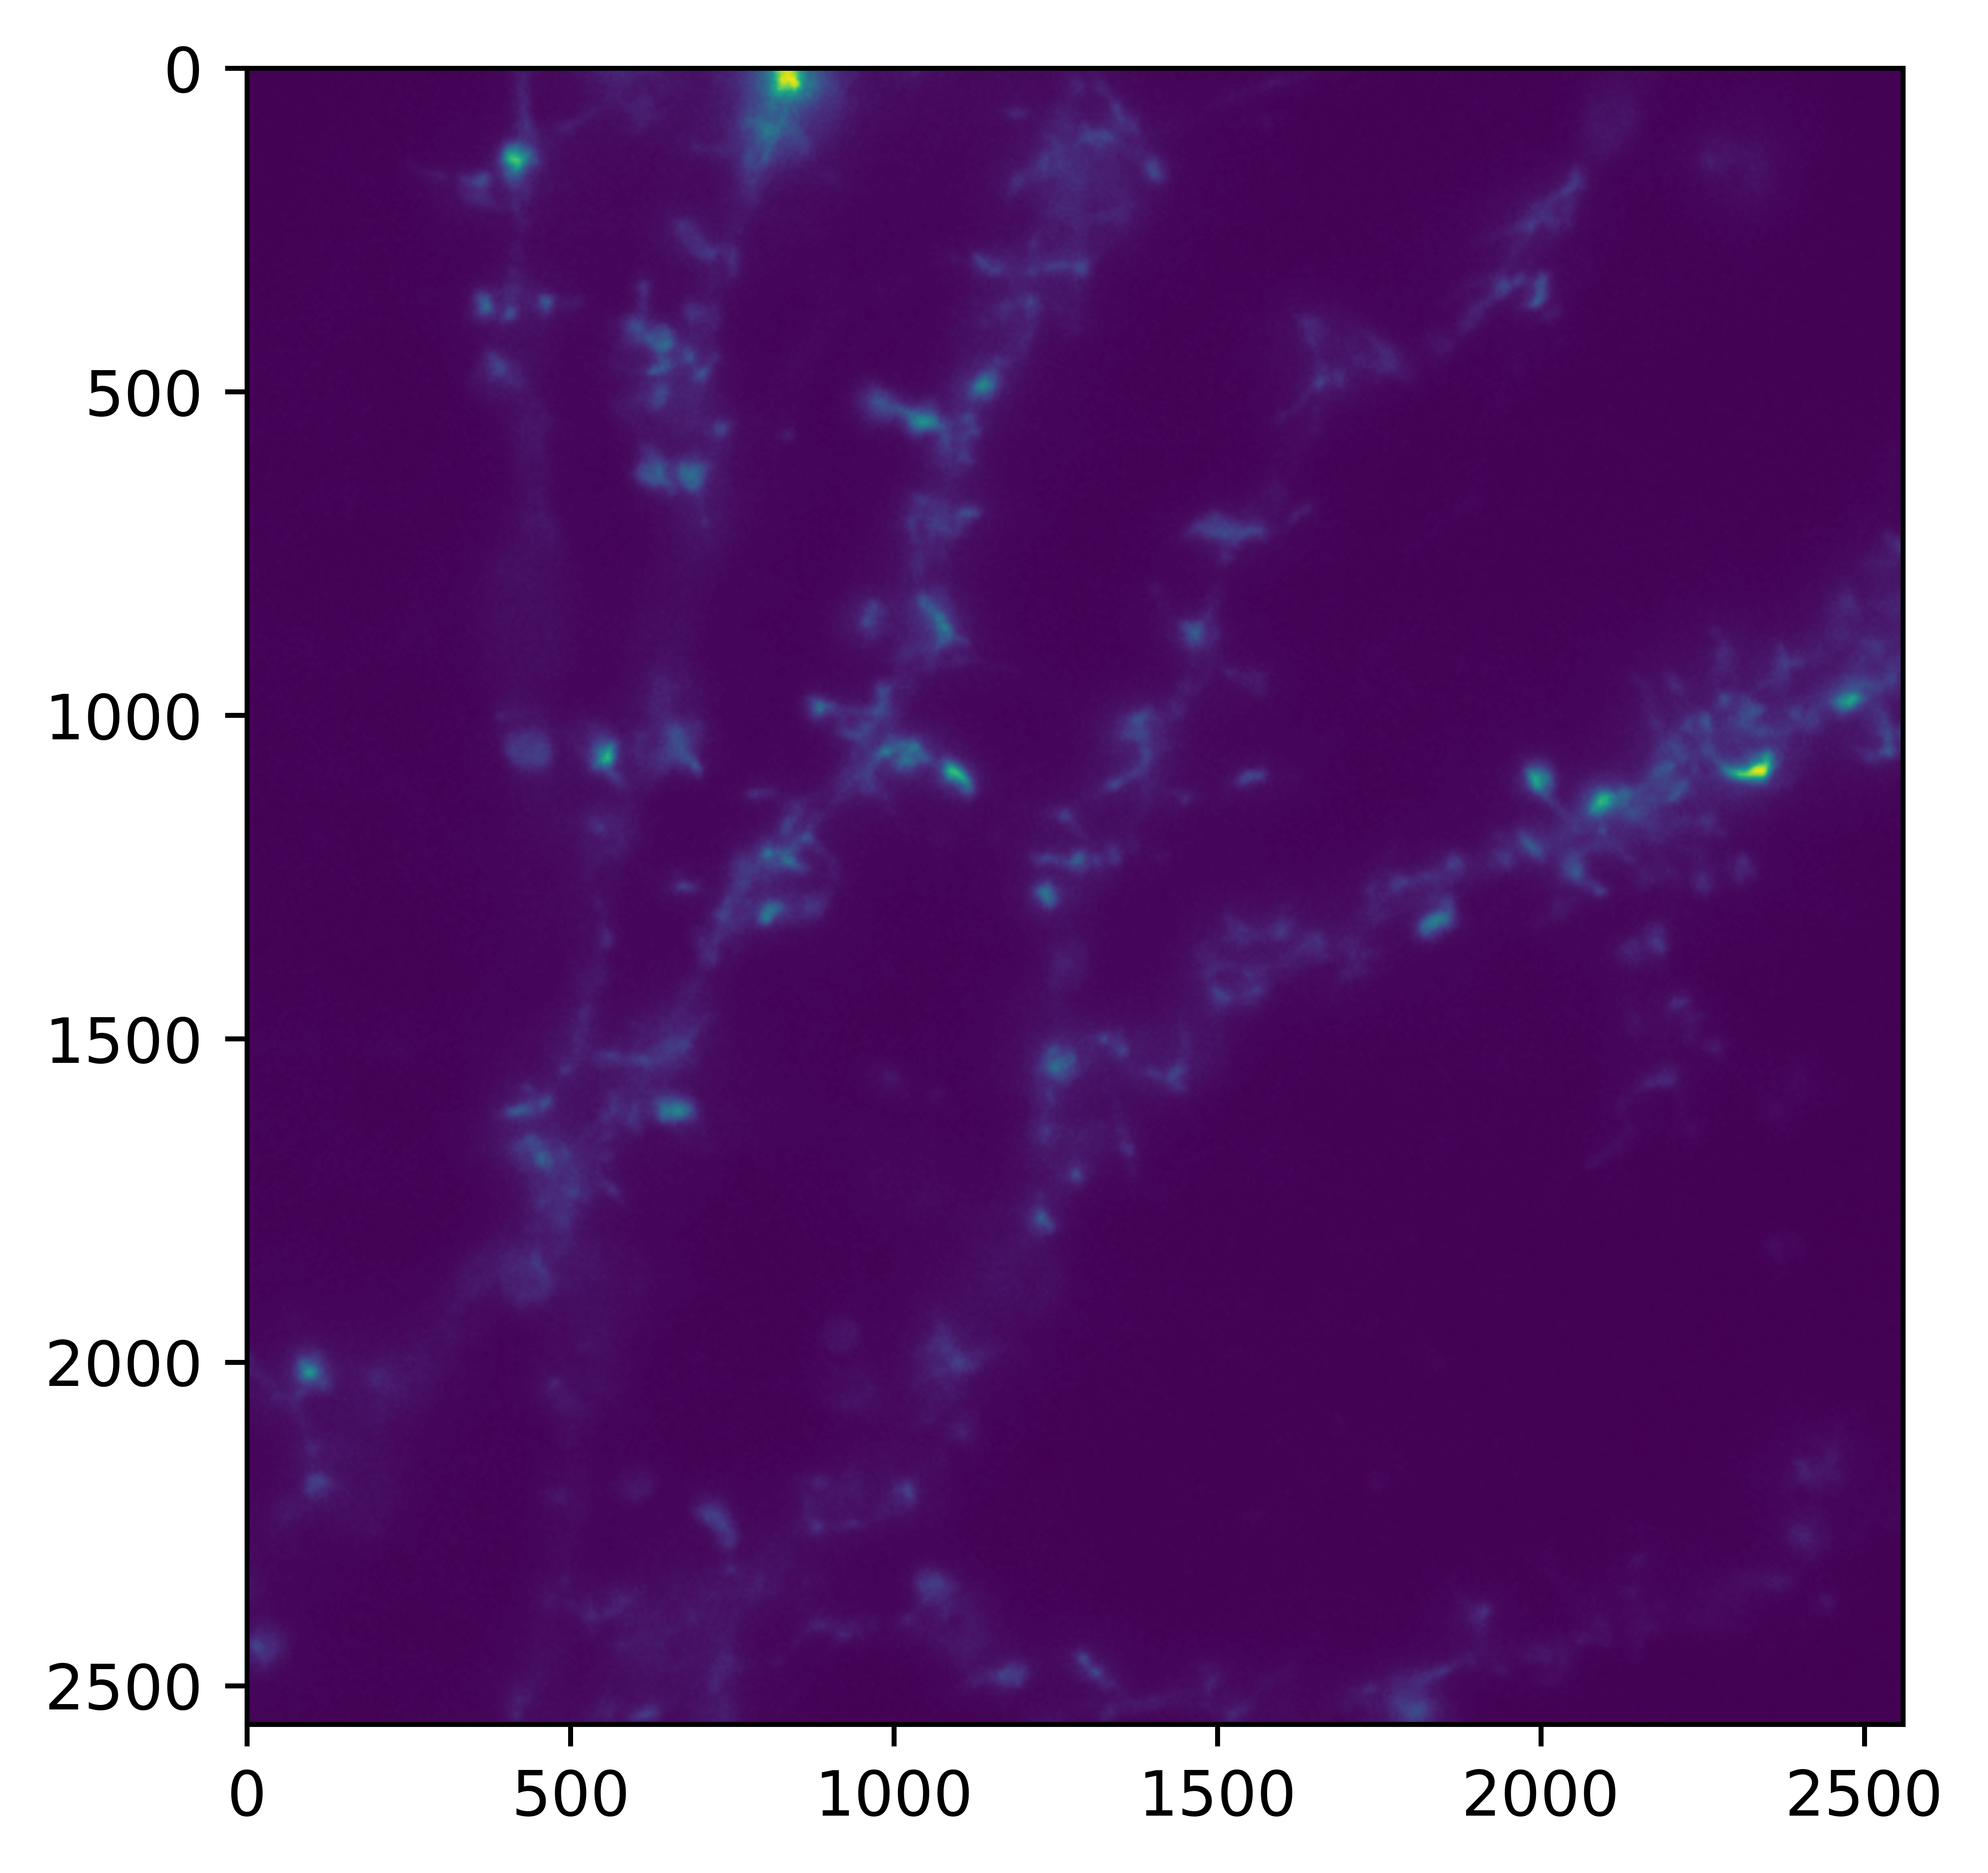

In [119]:
# Open the TIFF movie
with tifffile.TiffFile('Examples/B1_Composite.tif') as tif:
    # Get the number of frames in the movie
    n_frames = len(tif.pages)

    # Read all frames of the movie and store them as a numpy array
    movie = np.zeros((n_frames, tif.pages[0].shape[0], tif.pages[0].shape[1]), dtype='uint16')
    for i in range(n_frames):
        movie[i,:,:] = tif.pages[i].asarray()

    # Print relevant information about the movie
    print('Number of frames: {}'.format(n_frames))
    print('Shape of each frame: {}'.format(tif.pages[0].shape))
    print('Data type of each pixel: {}'.format(tif.pages[0].dtype))

# Display the first frame of the movie
plt.figure(dpi=1000)
plt.imshow(movie[0,:,:])
plt.show()

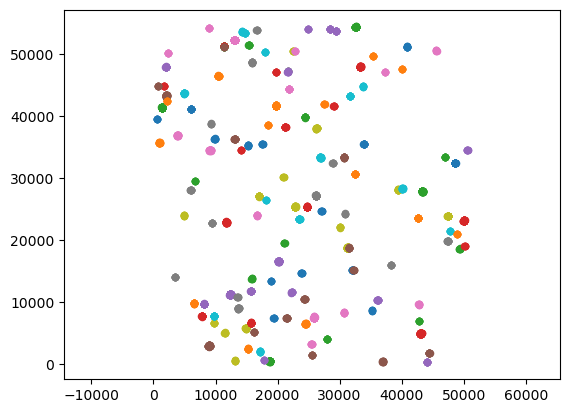

In [120]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Step 1: Load post-synaptic marker (e.g., Homer, PSD95) ThunderSTORM data
path = r'C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples'
outputindex = os.path.basename(os.path.dirname(path))
dim = 2
picasso = 0  # if Picasso = 1, otherwise = 0
synapse_size = 50  # cluster size in nm
min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius for cluster filtering

root = Tk()
root.withdraw()
# file_path = filedialog.askopenfilename(initialdir=path, title="Select the Homer (or synaptic marker) file to process",
#                                        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
file_path = r"C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples\B1_aHomer_corrected.csv"

try:
    ThunderSTORM1 = pd.read_csv(file_path, sep=',', skiprows=1, header=None)
except Exception:
    ThunderSTORM1 = pd.read_excel(file_path, header=None)

if picasso == 1:
    ThunderSTORM1.iloc[:, 1] = ThunderSTORM1.iloc[:, 1] + 1

ThunderSTORM = [ThunderSTORM1.values]
if dim == 3:
    palmX = ThunderSTORM[0][:, 2]
    palmY = ThunderSTORM[0][:, 3]
    palmZ = ThunderSTORM[0][:, 4]
    data_Syn = np.column_stack((palmX, palmY, palmZ))
elif dim == 2:
    palmX = ThunderSTORM[0][:, 2]
    palmY = ThunderSTORM[0][:, 3]
    data_Syn = np.column_stack((palmX, palmY))

# Finding clusters
db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
Class = db.labels_
type_ = np.array([1 if label != -1 else 0 for label in Class])



# Make new matrix
cluster_avgs = []
if dim == 3:
    Syn = np.column_stack((palmX, palmY, 0.79 * palmZ, Class, type_))
    # Separate and plot clusters
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for k in np.unique(Class):
        if k != -1:
            cluster_points = Syn[Syn[:, 3] == k]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=20)
elif dim == 2:
    Syn = np.column_stack((palmX, palmY, Class, type_))
    # Separate and plot clusters
    plt.figure()

    for k in np.unique(Class):
        if k != -1:
            cluster_points = Syn[Syn[:, 2] == k]
            cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
plt.axis('equal')
# plt.xlim(500, 570)
# plt.ylim(39530, 39600)
plt.show()

2371.544716691471 2550.2734613897615 24.8349862204683 15.472835990614302


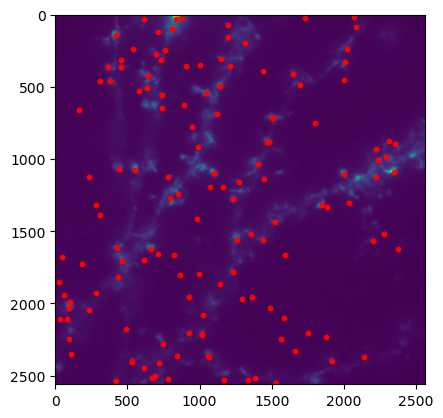

In [121]:
# print(cluster_avgs)
xs = [pt[0]/21.34 for pt in cluster_avgs]
ys = [pt[1]/21.34 for pt in cluster_avgs]
print(max(xs), max(ys), min(xs), min(ys))
plt.figure()
plt.imshow(movie[0,:,:])
plt.scatter(xs, ys, s=10, color='r')
plt.show()

- Check background LifeAct for high enough intensity

- 

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# read the csv file into a pandas dataframe
df = pd.read_csv(r'Examples\B1_GluA1_corrected.csv', delimiter=',')

# extract the x and y columns
x = df['x [nm]']/21.34
y = df['y [nm]']/21.34

In [240]:
from sklearn.cluster import DBSCAN

def filter_and_cluster_points(xs, ys, N, R, eps, min_samples):
    xs = np.array(xs)
    ys = np.array(ys)
    points = np.array(list(zip(xs, ys)))
    kdtree = KDTree(points)

    # Find points with at least N other points within radius R
    neighbors = kdtree.query_ball_point(points, R)
    neighbor_counts = np.array([len(neighbors_i) - 1 for neighbors_i in neighbors])  # Subtract 1 to exclude the point itself
    filtered_indices = np.where(neighbor_counts >= N)

    # Filtered points
    filtered_points = points[filtered_indices]

    # Cluster the filtered points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(filtered_points)
    labels = clustering.labels_

    # Calculate cluster centers (mean of points in each cluster)
    cluster_centers = np.array([filtered_points[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])

    # Assign each point to its nearest cluster center
    assignments = kdtree.query(cluster_centers, k=1)[1]

    return filtered_points, cluster_centers, assignments

def filter_and_cluster_points_originals(xs, ys, N, R, eps, min_samples):
    xs = np.array(xs)
    ys = np.array(ys)
    points = np.array(list(zip(xs, ys)))
    kdtree = KDTree(points)

    # Find points with at least N and N/2 other points within radius R
    neighbors = kdtree.query_ball_point(points, R)
    neighbor_counts = np.array([len(neighbors_i) - 1 for neighbors_i in neighbors])  # Subtract 1 to exclude the point itself
    filtered_indices = np.where(neighbor_counts >= N)
    filtered_indices_2 = np.where(neighbor_counts >= N/2)

    # Filtered points
    filtered_points = points[filtered_indices]
    filtered_points_2 = points[filtered_indices_2]

    # Cluster the filtered points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(filtered_points)
    labels = clustering.labels_

    # Calculate cluster centers (mean of points in each cluster)
    cluster_centers = np.array([filtered_points[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])

    # Find all original points within radius R2 of each cluster center
    points_near_centers = np.unique(np.concatenate([kdtree.query_ball_point(center) for center in cluster_centers]))

    # Get the coordinates of the points near the cluster centers
    points_near_centers_coords = points[points_near_centers]

    return points_near_centers_coords, cluster_centers

def cluster_points(xs, ys, eps, min_samples):
    xs = np.array(xs)
    ys = np.array(ys)
    points = np.array(list(zip(xs, ys)))
    kdtree = KDTree(points)

    # Cluster the points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_

    # Get the indices of points belonging to clusters (excluding noise points with label -1)
    clustered_indices = np.where(labels != -1)

    # Get the coordinates of the clustered points
    clustered_points = points[clustered_indices]

    # Calculate cluster centers (mean of points in each cluster)
    cluster_centers = np.array([points[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])

    return clustered_points, cluster_centers

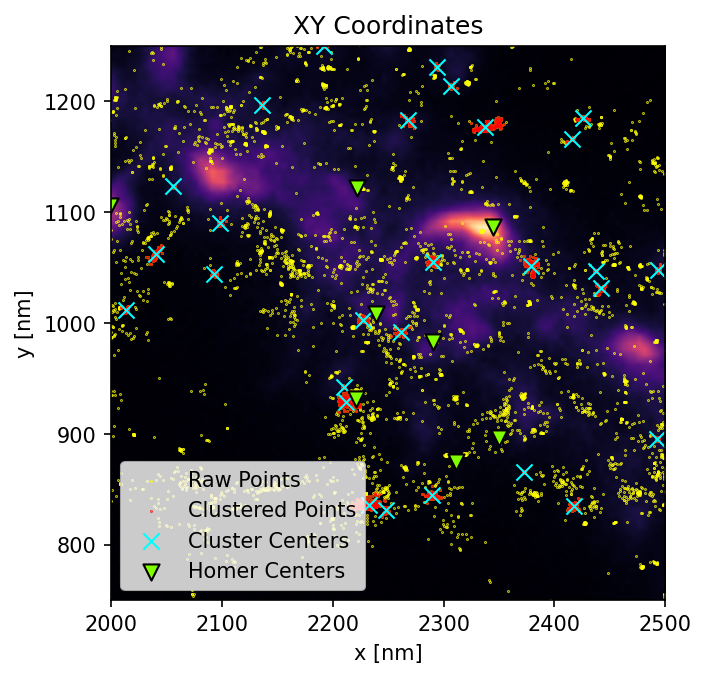

In [273]:
# filtered_xs, filtered_ys = filter_points(x, y, 65, 15)
# filtered_points, cluster_centers, assignments = filter_and_cluster_points(x, y, 65, 15, 10, 15)
# filtered_points, cluster_centers = filter_and_cluster_points_originals(x, y, 65, 15, 15, 10, 23)
filtered_points, cluster_centers = cluster_points(x, y, 5, 30)

# Get xs and ys
filtered_xs = [point[0] for point in filtered_points]
filtered_ys = [point[1] for point in filtered_points]
center_xs = [point[0] for point in cluster_centers]
center_ys = [point[1] for point in cluster_centers]

x_delta = 0
y_delta = 0
scale = 1
x_lim = (2000, 2500)
y_lim = (750, 1250)
plot_map()

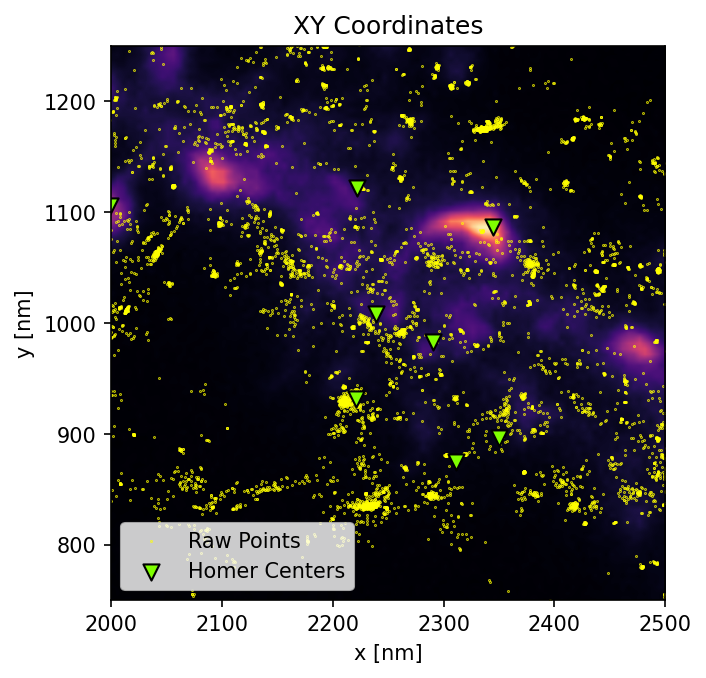

In [255]:
plot_map(True, False, True, False)

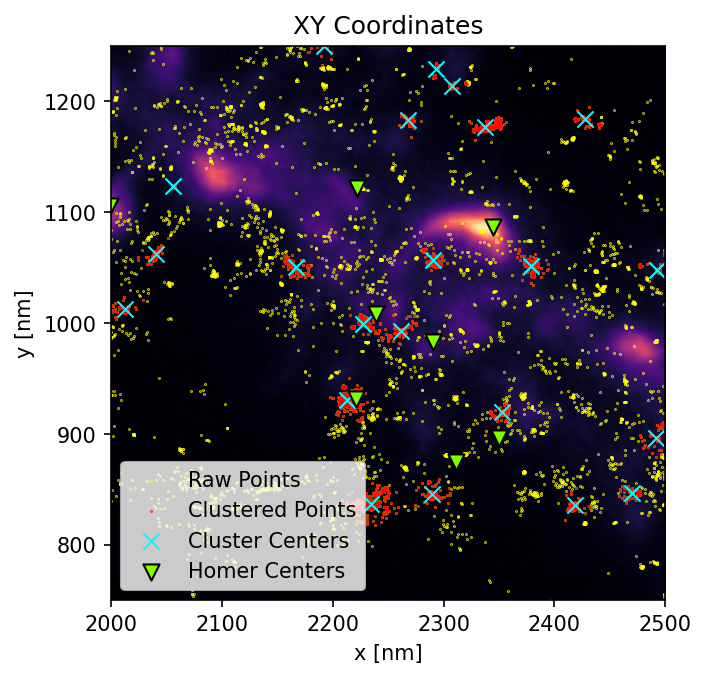

In [262]:
x_delta = 0
y_delta = 0
scale = 1
# x_lim = (2150, 2400)
# y_lim = (800, 1150)
x_lim = (2000, 2500)
y_lim = (750, 1250)

def plot_map(homer=True, centers=True, raw=True, clusters=True, background=True):
    scaled_x_lim = ((x_lim[0]+x_delta) - ((x_lim[1]-x_lim[0])*(scale-1)/2), (x_lim[1]+x_delta) + ((x_lim[1]-x_lim[0])*(scale-1)/2))
    scaled_y_lim = ((y_lim[0]+y_delta) - ((y_lim[1]-y_lim[0])*(scale-1)/2), (y_lim[1]+y_delta) + ((y_lim[1]-y_lim[0])*(scale-1)/2))
    plt.figure(dpi=150)
    if raw:
        plt.scatter(x, y, s=(0.1/np.sqrt(scale)), color='yellow', label="Raw Points")
    if clusters:
        plt.scatter(filtered_xs, filtered_ys, s=(0.1/np.sqrt(scale)), color='red', label="Clustered Points")
    if centers:
        plt.scatter(center_xs, center_ys, marker='x', linewidths=(1/np.sqrt(scale)), s=(60/np.sqrt(scale)), color='aqua', label='Cluster Centers')
    if homer:
        plt.scatter(xs, ys, s=(60/np.sqrt(scale)), marker='v', color='chartreuse', edgecolor='black', label="Homer Centers")
    plt.xlabel('x [nm]')
    plt.ylabel('y [nm]')
    plt.title('XY Coordinates')
    if background:
        plt.imshow(movie[0,:,:], cmap='magma')
    plt.xlim(scaled_x_lim[0], scaled_x_lim[1])
    plt.ylim(scaled_y_lim[0], scaled_y_lim[1])
    plt.legend(loc='lower left')
    plt.show()
    
# plot_map(True, False, True, False)
plot_map()
# plot_map(True, False, False, True)